<a href="https://colab.research.google.com/github/Yasmeen-Akl/Graduation-Project/blob/main/sign_language_graduation_project_preprocessing_and_words_model_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ranemelbasuony","key":"b8baaa2e3b618705252a51882f18a016"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/root/.kaggle"


In [ ]:
!kaggle datasets download -d yousefdotpy/karsl-502


Dataset URL: https://www.kaggle.com/datasets/yousefdotpy/karsl-502
License(s): unknown
100% 23.7G/23.7G [21:05<00:00, 22.3MB/s]
100% 23.7G/23.7G [21:05<00:00, 20.1MB/s]


In [ ]:
!unzip karsl-502


Streaming output truncated to the last 5000 lines.
  inflating: 03/03/train/0500/03_03_0500_(17_12_17_17_49_04)_c/03_03_0500_(17_12_17_17_49_04)_c_0059.jpg  
  inflating: 03/03/train/0500/03_03_0500_(17_12_17_17_49_04)_c/03_03_0500_(17_12_17_17_49_04)_c_0060.jpg  
  inflating: 03/03/train/0500/03_03_0500_(17_12_17_17_49_04)_c/03_03_0500_(17_12_17_17_49_04)_c_0061.jpg  
  inflating: 03/03/train/0500/03_03_0500_(17_12_17_17_49_04)_c/03_03_0500_(17_12_17_17_49_04)_c_0062.jpg  
  inflating: 03/03/train/0500/03_03_0500_(17_12_17_17_49_07)_c/03_03_0500_(17_12_17_17_49_07)_c_0001.jpg  
  inflating: 03/03/train/0500/03_03_0500_(17_12_17_17_49_07)_c/03_03_0500_(17_12_17_17_49_07)_c_0002.jpg  
  inflating: 03/03/train/0500/03_03_0500_(17_12_17_17_49_07)_c/03_03_0500_(17_12_17_17_49_07)_c_0003.jpg  
  inflating: 03/03/train/0500/03_03_0500_(17_12_17_17_49_07)_c/03_03_0500_(17_12_17_17_49_07)_c_0004.jpg  
  inflating: 03/03/train/0500/03_03_0500_(17_12_17_17_49_07)_c/03_03_0500_(17_12_17_17_49_07)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mv folder1/01/train /content/drive/MyDrive/folder1/


^C


In [ ]:
!pip install mediapipe seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 59.8 MB/s eta 0:00:00


In [ ]:
import mediapipe as mp
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import os
import shutil
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
np.random.seed(42)

In [ ]:
# Create a Holistic object to detect pose, face, and hands keypoints
mp_holistic = mp.solutions.holistic

# Drawing utilities
mp_drawing = mp.solutions.drawing_utils

In [ ]:
def mediapipe_detection(image, model):

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [ ]:
def draw_styled_landmarks(image, results):

    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [ ]:
def adjust_landmarks(arr,center):

    # Reshape the array to have shape (n, 3)
    arr_reshaped = arr.reshape(-1, 3)

    # Repeat the center array to have shape (n, 3)
    center_repeated = np.tile(center, (len(arr_reshaped), 1))

    # Subtract the center array from the arr array
    arr_adjusted = arr_reshaped - center_repeated

    # Reshape arr_adjusted back to shape (n*3,)
    arr_adjusted = arr_adjusted.reshape(-1)
    return(arr_adjusted)

In [ ]:
def extract_keypoints(results):

    pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    nose=pose[:3]
    lh_wrist=lh[:3]
    rh_wrist=rh[:3]
    pose_adjusted = adjust_landmarks(pose,nose)
    lh_adjusted = adjust_landmarks(lh,lh_wrist)
    rh_adjusted = adjust_landmarks(rh,rh_wrist)
    return pose_adjusted, lh_adjusted, rh_adjusted

In [ ]:
# Define the different ranges
ranges = [(111, 124)]

# Initialize an empty list to store the results
selected_words = []

# Iterate over each range
for start, end in ranges:
    # Extend the list with zero-padded numbers in the current range
    selected_words.extend([str(num).zfill(4) for num in range(start, end)])

# Print the result
print(selected_words)

['0111', '0112', '0113', '0114', '0115', '0116', '0117', '0118', '0119', '0120', '0121', '0122', '0123']


In [ ]:
numbers = [
    92, 100, 113, 115, 116, 117, 130, 168, 173, 237, 238, 254, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299,
    356, 357, 359, 362, 365, 366, 367, 369, 371, 374, 376, 378, 380, 382, 383, 384, 385, 386, 387, 388, 393, 395, 396,
    494, 497, 499, 502, 109, 122, 137, 145, 158, 167, 179, 182, 201, 215, 219, 223, 230, 246, 255, 263, 271, 275, 281,
    285, 310, 320, 324, 335, 340, 345, 352, 373, 379, 381, 384, 389, 391, 396, 403, 409, 411, 416, 421, 430, 445, 452,
    460, 472, 478, 485, 487, 491, 493, 496,
]

# Format numbers using zfill(4) and print
selected_words = [str(num).zfill(4) for num in numbers]
print(selected_words)

['0092', '0100', '0113', '0115', '0116', '0117', '0130', '0168', '0173', '0237', '0238', '0254', '0289', '0290', '0291', '0292', '0293', '0294', '0295', '0296', '0297', '0298', '0299', '0356', '0357', '0359', '0362', '0365', '0366', '0367', '0369', '0371', '0374', '0376', '0378', '0380', '0382', '0383', '0384', '0385', '0386', '0387', '0388', '0393', '0395', '0396', '0494', '0497', '0499', '0502', '0109', '0122', '0137', '0145', '0158', '0167', '0179', '0182', '0201', '0215', '0219', '0223', '0230', '0246', '0255', '0263', '0271', '0275', '0281', '0285', '0310', '0320', '0324', '0335', '0340', '0345', '0352', '0373', '0379', '0381', '0384', '0389', '0391', '0396', '0403', '0409', '0411', '0416', '0421', '0430', '0445', '0452', '0460', '0472', '0478', '0485', '0487', '0491', '0493', '0496']


In [ ]:
def make_keypoint_arrays(path,signer,split):
    """This function generates numpy arrays of keypoints for each video in the specified folder location.
    Args:
      signer(int): the signer of interest. Could be 01 or 02 or 03
      split(str): can be 'train', 'test' or 'val'
    """
    os.makedirs('karsl-502',exist_ok = True)
    os.makedirs(f'karsl-502/{signer}',exist_ok = True)
    os.makedirs(f'karsl-502/{signer}/{split}',exist_ok = True)
    working_path = f'karsl-502/{signer}/{split}'
    words_folder = os.path.join(path,str(signer),str(signer), split)

    # Loop through all the subfolders in the folder
    for word in tqdm(selected_words):

        video_files = os.listdir(os.path.join(words_folder, word))
          # Loop through the video files
        for video_file in video_files:
                # Open the video file
            video = sorted(os.listdir(os.path.join(words_folder, word, video_file)))

            # Initialize the list of keypoints for this video
            pose_keypoints, lh_keypoints, rh_keypoints = [], [], []
            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
              # Loop through the video frames
              for frame in video:
                  # Perform any necessary preprocessing on the frame (e.g., resizing, normalization)
                frame = os.path.join(words_folder, word, video_file,frame)
                frame = cv2.imread(frame)
#                 frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                  # Normalize pixel values to the range [0, 1]
                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Extract keypoints
                pose, lh, rh = extract_keypoints(results)
                # Add the keypoints to the list for this video
                pose_keypoints.append(pose)
                lh_keypoints.append(lh)
                rh_keypoints.append(rh)
                # Save the keypoints for this video to a numpy array
                pose_directory = os.path.join(working_path, word,'pose_keypoints')
                lh_directory = os.path.join(working_path, word,'lh_keypoints')
                rh_directory = os.path.join(working_path, word,'rh_keypoints')

                if not os.path.exists(pose_directory):
                    os.makedirs(pose_directory)

                if not os.path.exists(lh_directory):
                    os.makedirs(lh_directory)

                if not os.path.exists(rh_directory):
                    os.makedirs(rh_directory)

                pose_path = os.path.join(pose_directory, video_file)
                np.save(pose_path, pose_keypoints)

                lh_path = os.path.join(lh_directory, video_file)
                np.save(lh_path, lh_keypoints)

                rh_path = os.path.join(rh_directory, video_file)
                np.save(rh_path, rh_keypoints)

In [ ]:
!ls /content/drive/MyDrive/


 01					    ES_AI.pdf	  html.txt
 02					    finish	 'm '
 03					    folder1	  Oesjaarfilms
 2-3					    folder1_new  'ranem elbasuony.pdf'
'2-3 done'				    folder2	  RNN
 5a4a9126-230f-467f-b139-88a79869dac4.jpg   folder2_new  'text 2.txt'
'Colab Notebooks'			    folder3	  text.txt
'Copy of MOO_6047.jpg'			    folder3_new  'Word count '
'Coursera certification '		    html.gdoc


In [ ]:
make_keypoint_arrays('/content/drive/MyDrive/01','01','train')
make_keypoint_arrays('/content/drive/MyDrive/01','01','test')
make_keypoint_arrays('/content/drive/MyDrive/02','02','train')
make_keypoint_arrays('/content/drive/MyDrive/02','02','test')
make_keypoint_arrays('/content/drive/MyDrive/03','03','train')
make_keypoint_arrays('/content/drive/MyDrive/03','03','test')


  0%|          | 0/100 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/01/01/01/train/0092'

In [ ]:
karsl_df = pd.read_excel('/kaggle/input/sameh-alaa/KARSL-502_Labels.xlsx')
mask = []
for i in karsl_df['SignID'].values:
    if str(i).zfill(4) in selected_words :
        mask.append(True)
    else :
        mask.append(False)

karsl_6 = karsl_df[mask].reset_index(drop=True)
karsl_6

,SignID,Sign-Arabic,Sign-English
0,92,مستشفى,hospital
1,100,صيدلية,pharmacy
2,109,معمل التحاليل / مختبر,analysis laboratory
3,113,زكام,cold
4,115,صداع,headache
...,...,...,...
93,494,موظف,agent
94,496,صيدلي,pharmacist
95,497,طبيب,doctor
96,499,ممرض,orderly


In [ ]:
w2id = {w:i for w,i in zip(karsl_6['Sign-Arabic'].values,karsl_6['SignID'].values  )}
w2id

{'مستشفى': 92,
 'صيدلية': 100,
 'معمل التحاليل / مختبر': 109,
 'زكام': 113,
 'صداع': 115,
 'ألم': 116,
 'حمى': 117,
 'أزمة قلبية': 122,
 'حساسية': 130,
 'مرهم': 137,
 'توحد / أوتيزم': 145,
 'عصب': 158,
 'يصعد': 167,
 'ينزل': 168,
 'يمشي': 173,
 'يسقي': 179,
 'يساعد': 182,
 'توأم': 201,
 'ابن العم': 215,
 'طلاق': 219,
 'طفل': 223,
 'غني': 230,
 'خائف': 237,
 'سعيد (مسرور)': 238,
 'ودود': 246,
 'شعور': 254,
 'تعب': 255,
 'صدق': 263,
 'شفقة': 271,
 'بعيد': 275,
 'داخل': 281,
 'هنا': 285,
 'أهلا وسهلاً': 289,
 'السلام عليكم': 290,
 'تفضل': 291,
 'جار': 292,
 'شكراً': 293,
 'صديق': 294,
 'ضيف': 295,
 'عدو': 296,
 'عيب': 297,
 'هدية': 298,
 'بيت': 299,
 'شماعة ( مشجب)': 310,
 'مجمد (فريزر)': 320,
 'إبريق': 324,
 'شريط كاست': 335,
 'كاميرا فوتوغرافية': 340,
 'مدفأة': 345,
 'قابس كهربائي ( فيش)': 352,
 'الله تعالى': 356,
 'محمد رسول الله': 357,
 'القرآن الكريم': 359,
 'أركان الإسلام': 362,
 'يصلي / الصلاة': 365,
 'الزكاة': 366,
 'الصوم': 367,
 'الحج': 369,
 'رسول': 371,
 'القضاء والقدر': 373,


In [ ]:
words= np.array([v for v in karsl_6['Sign-Arabic']])
print(words)

['مستشفى' 'صيدلية' 'معمل التحاليل / مختبر' 'زكام' 'صداع' 'ألم' 'حمى'
 'أزمة قلبية' 'حساسية' 'مرهم' 'توحد / أوتيزم' 'عصب' 'يصعد' 'ينزل' 'يمشي'
 'يسقي' 'يساعد' 'توأم' 'ابن العم' 'طلاق' 'طفل' 'غني' 'خائف' 'سعيد (مسرور)'
 'ودود' 'شعور' 'تعب' 'صدق' 'شفقة' 'بعيد' 'داخل' 'هنا' 'أهلا وسهلاً'
 'السلام عليكم' 'تفضل' 'جار' 'شكراً' 'صديق' 'ضيف' 'عدو' 'عيب' 'هدية' 'بيت'
 'شماعة ( مشجب)' 'مجمد (فريزر)' 'إبريق' 'شريط كاست' 'كاميرا فوتوغرافية'
 'مدفأة' 'قابس كهربائي ( فيش)' 'الله تعالى' 'محمد رسول الله'
 'القرآن الكريم' 'أركان الإسلام' 'يصلي / الصلاة' 'الزكاة' 'الصوم' 'الحج'
 'رسول' 'القضاء والقدر' 'أركان الصلاة' 'النية' 'طهارة' 'مبطلات الصلاة'
 'تيمم' 'يتوضأ / وضوء' 'يؤذن' 'مسح على الخفين' 'صلاة الفجر' 'صلاة الظهر'
 'صلاة العصر' 'صلاة المغرب' 'صلاة العشاء' 'خطبة' 'خطيب' 'مسجد' 'إمام'
 'سورة الفاتحة' 'مكة' 'مزدلفة' 'طواف' 'المسجد الأقصى' 'الشرك بالله'
 'النار' 'آدم' 'عقوق الوالدين' 'مصور فوتوغرافي' 'سفير'
 'ولي عهد / وكيل وزارة' 'طيار' 'حلاق' 'معلم / مدرس' 'فلاح' 'موظف' 'صيدلي'
 'طبيب' 'ممرض' 'تعيين']

In [ ]:
label_map = {label:num for num, label in enumerate(words)}
print(label_map)

{'مستشفى': 0, 'صيدلية': 1, 'معمل التحاليل / مختبر': 2, 'زكام': 3, 'صداع': 4, 'ألم': 5, 'حمى': 6, 'أزمة قلبية': 7, 'حساسية': 8, 'مرهم': 9, 'توحد / أوتيزم': 10, 'عصب': 11, 'يصعد': 12, 'ينزل': 13, 'يمشي': 14, 'يسقي': 15, 'يساعد': 16, 'توأم': 17, 'ابن العم': 18, 'طلاق': 19, 'طفل': 20, 'غني': 21, 'خائف': 22, 'سعيد (مسرور)': 23, 'ودود': 24, 'شعور': 25, 'تعب': 26, 'صدق': 27, 'شفقة': 28, 'بعيد': 29, 'داخل': 30, 'هنا': 31, 'أهلا وسهلاً': 32, 'السلام عليكم': 33, 'تفضل': 34, 'جار': 35, 'شكراً': 36, 'صديق': 37, 'ضيف': 38, 'عدو': 39, 'عيب': 40, 'هدية': 41, 'بيت': 42, 'شماعة ( مشجب)': 43, 'مجمد (فريزر)': 44, 'إبريق': 45, 'شريط كاست': 46, 'كاميرا فوتوغرافية': 47, 'مدفأة': 48, 'قابس كهربائي ( فيش)': 49, 'الله تعالى': 50, 'محمد رسول الله': 51, 'القرآن الكريم': 52, 'أركان الإسلام': 53, 'يصلي / الصلاة': 54, 'الزكاة': 55, 'الصوم': 56, 'الحج': 57, 'رسول': 58, 'القضاء والقدر': 59, 'أركان الصلاة': 60, 'النية': 61, 'طهارة': 62, 'مبطلات الصلاة': 63, 'تيمم': 64, 'يتوضأ / وضوء': 65, 'يؤذن': 66, 'مسح على الخفين':

In [ ]:
def preprocess_data(data_path,signers,split,f_avg):
    """"
    This function loads the keypoints arrays for each video sequence of each word performed by the given signers, and extracts
    a subsequence of length 'f_avg' from each sequence. Then it converts the sequences and labels to numpy arrays and returns
    them as X and y.

    Args:
        signers(list): the signers of interest.
        split(str): can be 'train' or 'test'.
        f_avg(int): threshold for frame sampling.

    Returns:
        X(numpy.ndarray): array of sequences
        y(numpy.ndarray): array of one-hot encoded sign labels
    """

    # Initialize the lists of sequences and labels
    sequences, labels = [], []

    # Iterate through the list of words
    for word in tqdm(words):
        for signer in signers:
            # Iterate through the numpy arrays contained in the directory mentioned below
            for sequence in os.listdir(os.path.join(data_path,str(signer), split, str(w2id[word] ).zfill(4), 'lh_keypoints')):
                 # Load the left hand array
                res_lh = np.load(os.path.join(data_path,str(signer), split, str(w2id[word] ).zfill(4), 'lh_keypoints', sequence))

                # Determine how many rows to select
                num_frames = min(res_lh.shape[0], f_avg)
                res_lh = res_lh[:num_frames,:]
                while num_frames < f_avg:
                    res_lh = np.concatenate((res_lh, np.expand_dims(res_lh[-1,:], axis=0)), axis=0)
                    num_frames += 1

                # Load the right hand array
                res_rh = np.load(os.path.join(data_path,str(signer), split, str(w2id[word]).zfill(4), 'rh_keypoints', sequence))

                # Determine how many rows to select
                num_frames = min(res_rh.shape[0], f_avg)
                res_rh = res_rh[:num_frames,:]
                while num_frames < f_avg:
                    res_rh = np.concatenate((res_rh, np.expand_dims(res_rh[-1,:], axis=0)), axis=0)
                    num_frames += 1

                # Load the pose array
                res_pose = np.load(os.path.join(data_path,str(signer), split, str(w2id[word]).zfill(4), 'pose_keypoints', sequence))

                # Determine how many rows to select
                num_frames = min(res_pose.shape[0], f_avg)
                res_pose = res_pose[:num_frames,:]
                while num_frames < f_avg:
                    res_pose = np.concatenate((res_pose, np.expand_dims(res_pose[-1,:], axis=0)), axis=0)
                    num_frames += 1

                # Append the subsequence to the list of sequences
                sequences.append(np.concatenate((res_pose,res_lh, res_rh), axis=1))
                # Append the label to the list of labels
                labels.append(label_map[word])
    # Convert the lists of sequences and labels to numpy arrays
    X = np.array(sequences)
    y = to_categorical(labels).astype(int)

    return X, y

In [ ]:
#train and validation splits
data_path = '/kaggle/working/karsl-502'
X_train,y_train=preprocess_data(data_path,['01','02','03'],'train',48)
# X_train,y_train=preprocess_data(data_path,['01','02'],'train',48)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

100%|██████████| 98/98 [00:22<00:00,  4.33it/s]


(9900, 48, 225)
(9900, 98)
(2476, 48, 225)
(2476, 98)


In [ ]:
#test split
# X_test,y_test=preprocess_data(data_path,['01','02'],'test',48)
X_test,y_test=preprocess_data(data_path,['01','02','03'],'test',48)
print(X_test.shape)
print(y_test.shape)

100%|██████████| 98/98 [00:04<00:00, 20.62it/s]


(2342, 48, 225)
(2342, 98)


In [ ]:
# Define the Bidirectional LSTM model with Attention


# model = tf.keras.Sequential([
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(len(words), activation='softmax')
# ])

import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dense(len(words), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Set up early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor for early stopping
    mode='min',  # Set mode to 'min' for minimizing the metric
    patience=10,  # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the best model weights
    verbose=1
)

In [ ]:
model_training_history = model.fit(X_train,
                                   y_train,
                                   batch_size=64,
                                   validation_data=(X_val,y_val),
                                   validation_batch_size=64,
                                   epochs=50,
                                   callbacks=[early_stopping])

Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - categorical_accuracy: 0.0409 - loss: 4.2220 - val_categorical_accuracy: 0.3021 - val_loss: 2.4512
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - categorical_accuracy: 0.4116 - loss: 1.9439 - val_categorical_accuracy: 0.6361 - val_loss: 1.1671
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - categorical_accuracy: 0.7126 - loss: 0.9028 - val_categorical_accuracy: 0.8502 - val_loss: 0.5154
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - categorical_accuracy: 0.8547 - loss: 0.4839 - val_categorical_accuracy: 0.9204 - val_loss: 0.3174
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - categorical_accuracy: 0.9267 - loss: 0.2615 - val_categorical_accuracy: 0.9285 - val_loss: 0.2776
Epoch 6/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - categorical_accuracy: 0.9425 - loss: 0.2080 - val_categorical_accuracy: 0.9338 - val_loss: 0.2639
Epoch 7/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - categorical_accuracy: 0.94

In [ ]:
# Evaluate the model on train data
model_evaluation_history = model.evaluate(X_train, y_train)

310/310 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - categorical_accuracy: 0.9887 - loss: 0.0445


In [ ]:
# Evaluate the model on test data
model_evaluation_history = model.evaluate(X_test, y_test)

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - categorical_accuracy: 0.9847 - loss: 0.0777


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

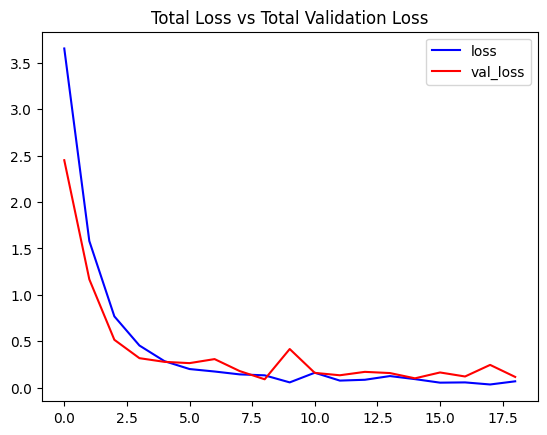

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
#Predicted sign
res = model.predict(X_test)
words[np.argmax(res[1])]

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


'مستشفى'

In [ ]:
#Real sign
words[np.argmax(y_test[1])]

'مستشفى'

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
#model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
#date_time_format = '%Y_%m_%d__%H_%M_%S'
#current_date_time_dt = dt.datetime.now()
#current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
#model_file_name = f'SamehAlaa_model_2_signers___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
#model.save(model_file_name)

In [ ]:
model_json = model.to_json()
with open("wordsnewww.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("wordsnewww.weights.h5")

In [ ]:
import pickle

# Replace `model` with your model instance
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved as 'model.pkl'")

Model saved as 'model.pkl'


In [ ]:
import pickle

# Load the model
with open('model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

print("Model loaded successfully")

Model loaded successfully


In [ ]:
yhat = model.predict(X_test)

In [ ]:
model.save_weights('model_weights.h5')
model.save('model.h5')

In [ ]:
def get_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
y = []
for v in ytrue:
    y.append(get_key_by_value(label_map, v))
print(y)

In [ ]:
y = [karsl_6[karsl_6['Sign-Arabic'] == v]['Sign-English'].values[0] for v in y]
print(y)

In [ ]:
ypred = []
for v in yhat:
    ypred.append(get_key_by_value(label_map, v))
print(ypred)

In [ ]:
ypred = [karsl_6[karsl_6['Sign-Arabic'] == v]['Sign-English'].values[0] for v in ypred]
print(ypred)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y and ypred are your target labels and predicted labels, respectively

# Select the first 20 classes
y_subset = y[:200]
ypred_subset = ypred[:200]

# Get unique class labels
class_labels = np.unique(y_subset)

# Compute confusion matrix
cm = confusion_matrix(y_subset, ypred_subset, labels=class_labels)

# Create a DataFrame from the confusion matrix
df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.3)  # for label size
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix - First 20 Classes")
plt.show()